# Validação dos conceitos SINKT (Extração + Estratégias)

<div>

<img src="imgs/new_rotated.jpg" alt="Description" style="display: block; margin: 20px auto; width: 40%;" />

</div>


**Estruturas & Modelos**

In [1]:
from enum import Enum
from langchain.chat_models import init_chat_model, BaseChatModel

class Models(str, Enum):
    GPT4_o = "openai:gpt-4o"
    GPT5_1 = "openai:gpt-5.1"
    CLAUDE4_5 = "anthropic:claude-opus-4-5"

def get_llm(model_name: Models) -> BaseChatModel:
    return init_chat_model(model_name.value)

In [ ]:
from pydantic import BaseModel, Field
from typing import List, Optional, Literal

class Concept(BaseModel):
    """Represents a single educational concept found in the text."""
    concept_name: str = Field(description="The formal name of the concept (e.g., 'Inductive Logic', 'Backpropagation').")
    chapter: List[int] = Field(description="The number of the current chapter, subchapter, etc (e.g., [1] for chapter 1, [1, 2] for subchapter 1.2, [1,2,5] for subsubchapter 1.2.5)")
    description: str = Field(description="A concise definition or summary of the concept based on the text.")

class PageExtraction(BaseModel):
    """Container for multiple concepts found on a specific page processing step."""
    concepts: List[Concept] = Field(description="List of concepts extracted from the current text window.")
    
class Relation(BaseModel):
    source: str = Field(description="The subject concept.")
    target: str = Field(description="The object concept.")
    # relation_type: Literal['prerequisite', 'including', 'part-of', 'property', 'definition']
    relation_type: Literal['prerequisite']
    context: Optional[str] = Field(description="Justification text.")

class ConceptList(BaseModel):
    concepts: List[Concept]
    
class RelationList(BaseModel):
    relations: List[Relation]

## Extração de dados

O SINKT já considera um dataset pronto para uso. Sendo assim essa seção busca extrair os conceitos de um ebook PDF. Primeiramente iremos transformar em Markdown, visto que é melhor utilizar texto puro ao invés de páginas de PDF. Além disso, essa proposta facilita a própria extração para o MAIC, posteriormente.


<div>

<img src="imgs/new_rotated.jpg" alt="Description" style="display: block; margin: 20px auto; width: 60%;" />

</div>



In [3]:
import unicodedata
import re
import xml.etree.ElementTree as ET
from xml.dom import minidom

def normalize_filename(s: str) -> str:
    """
    Remove accents, replace underscores and remove non-alphanumeric characters.
    
    :param s: String to be normalized
    """
    s = unicodedata.normalize('NFKD', s)
    s = ''.join(char for char in s if not unicodedata.combining(char))
    s = re.sub(r'\s+', '_', s)
    s = re.sub(r'[^\w_]', '', s)
    return s.lower()

def prettify_xml(elem: ET.Element) -> str:
    """
    Return a pretty-printed XML string for the Element.
    Strips the annoying extra newlines minidom likes to add.
    
    :param elem: Element (``ET.Element``)
    """
    rough_string = ET.tostring(elem, 'utf-8')
    reparsed = minidom.parseString(rough_string)
    # Filter out lines that are purely whitespace
    return '\n'.join([line for line in reparsed.toprettyxml(indent="   ").split('\n') if line.strip()])

Configuração inicial.

In [4]:
from dotenv import load_dotenv
import os
from pathlib import Path
from langsmith import Client
from openai import OpenAI
from langsmith.wrappers import wrap_openai

load_dotenv("../.env")

assert os.getenv("OPENAI_API_KEY"), "OPENAI_API_KEY not found"
assert os.getenv("ANTHROPIC_API_KEY"), "ANTHROPIC_API_KEY not found"
assert os.getenv("LANGSMITH_API_KEY"), "ANTHROPIC_API_KEY not found"

BOOK_NAME = 'LinuxFundamentals'
EBOOKS_PATH = Path('ebooks')
base_output_dir = EBOOKS_PATH / BOOK_NAME
os.makedirs(base_output_dir, exist_ok=True)

PDF_PATH = Path('../data/701-LinuxFundamentals_material_full_v14.pdf')

client = wrap_openai(OpenAI())
# client.

Primeiramente é criada a classe de conversão do PDF para markdown, utiliza-se da biblioteca Docling para realizar a conversão. Essa biblioteca permite extrair as imagens e tabelas do texto, posteriormente elas são incluídas no markdown final além de serem salvas juntas.

In [5]:
import os
from PyPDF2 import PdfReader

from docling.document_converter import DocumentConverter
import logging
from docling.datamodel.accelerator_options import AcceleratorDevice, AcceleratorOptions
from docling.datamodel.base_models import InputFormat, OutputFormat
from docling.datamodel.pipeline_options import (
    PdfPipelineOptions
    )
from docling.document_converter import DocumentConverter, PdfFormatOption, MarkdownFormatOption
from docling_core.types.doc import ImageRefMode, PictureItem, TableItem, DoclingDocument
from tqdm.notebook import tqdm_notebook

class PDFConversor():
    """
    Convert PDF to markdown.
    
    :param pdf_path: Path of the input pdf.
    :param output_dir: Path of the output.
    """
    def __init__(self, pdf_path: Path, output_dir: Path):
        self.input_doc_path: Path = pdf_path
        self.base_output_dir: Path = output_dir
        self.pipeline_options: PdfPipelineOptions = self._set_pipeline_options()
        self.document_converter: DocumentConverter = DocumentConverter(
            format_options={
                InputFormat.PDF: PdfFormatOption(pipeline_options=self.pipeline_options),
                OutputFormat.MARKDOWN: MarkdownFormatOption(image_mode=ImageRefMode.REFERENCED)
            },
        )
        self.last_page: int = self._get_no_pages()
        self.doc = None
       
    def _set_pipeline_options(self) -> PdfPipelineOptions:
        IMAGE_SCALE = 2.0
        
        pipeline_options = PdfPipelineOptions()
        pipeline_options.generate_picture_images = True
        pipeline_options.generate_page_images = True
        pipeline_options.images_scale = IMAGE_SCALE
        pipeline_options.do_ocr = False
        pipeline_options.do_table_structure = True
        pipeline_options.table_structure_options.do_cell_matching = True
        pipeline_options.ocr_options.lang = ["pt"]
        pipeline_options.accelerator_options = AcceleratorOptions(
            num_threads=4, device=AcceleratorDevice.CUDA
        )
        return pipeline_options

    
    def _get_no_pages(self) -> int:
        reader = PdfReader(self.input_doc_path)
        return len(reader.pages)
    
    def _replace_image_placeholders(selg, md_str: str, image_files: List[Path]) -> None:
        content = md_str
        for img in image_files:
            content = content.replace("<!-- image -->", f"![]({str(img).split('/')[-1]})", 1)
        return content
        
    def save_images(self, doc: DoclingDocument, output_dir: Path) -> List[str]:
        filenames = []
        for page in doc.pictures:
            # print(page)
            page_no = page.self_ref.split('/')[-1]
            page_image_filename = output_dir / f"{page_no}.png"
            print(page_image_filename)
            with page_image_filename.open("wb") as fp:
                page.image.pil_image.save(fp, format="PNG")
            filenames.append(page_image_filename.relative_to(self.base_output_dir))
        return filenames 
    
    def generate_markdown(self, concepts: List[Concept]) -> None:
        """
        Generate a folder for each concept, with the images captured and a ``document.md`` file.
        
        :param concepts: ``List[Concept]`` List of concepts, their pages must in crescent order and sequentially
        (e.g. Chapter 1, 2, 3...).
        """
        for idx in tqdm_notebook(range(len(concepts))):
            curr_chap: Concept = concepts[idx]
            init_page = curr_chap.page_start
            chap_name = normalize_filename(curr_chap.concept_name)

            output_concept_dir = self.base_output_dir / chap_name
            os.makedirs(output_concept_dir, exist_ok=True)
            
            next_page = self.last_page + 1 if idx == len(concepts) - 1 else concepts[idx + 1].page_start - 1

            doc = self.document_converter.convert(self.input_doc_path, page_range=[init_page, next_page]).document
            md_str = doc.export_to_markdown()

            img_filenames = self.save_images(doc, output_concept_dir)
            raw_markdown = self._replace_image_placeholders(md_str, img_filenames)

            with open(output_concept_dir / "document.md", "w") as f:
                f.write(raw_markdown)

``EBookExtractor`` é a classe principal, encapsulando a classe criada anteriormente e servindo como uma interface de mais alto nível.

In [6]:
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_core.documents.base import Document
from langchain_core.prompts import ChatPromptTemplate
# from langchain_openai import ChatOpenAI

class EbookExtractor():
    """
    Extract data from an ebook.
    
    :param pdf_file_path: The path of the desired pdf book.
    :param base_output_dir: Directory where the book is going to be saved.
    """
    def __init__(self, pdf_file_path: Path, base_output_dir: Path, llm: BaseChatModel):
        self.pages: List[Document] = None
        self.llm = llm
        self.pdf_conversor: PDFConversor = PDFConversor(pdf_file_path, base_output_dir)
        self.file_path: Path = pdf_file_path
        self._load_pdf_pages()
    
    def _load_pdf_pages(self) -> None:
        """Loads PDF and returns a list of Document objects (one per page)."""
        print(f"Loading PDF: {self.file_path}...")
        loader = PyMuPDFLoader(self.file_path)
        pages = loader.load()
        last_page = len(pages)
        print(f"Loaded {len(pages)} pages.")
        self.pages = pages
        
    
    def extract_toc_structure(self, end_toc_page = 5) -> PageExtraction:
        """
        Scans the first ``end_toc_page`` pages to find a Table of Contents or Summary.
        Returns a list of 'known concepts' to prime the main extractor.

        :param end_toc_page: The first pages where the summary appears. Default to 5.
        """
        print(f"Scouting Table of Contents (Pages 1-{end_toc_page})...")
        
        # Combine first pages (or fewer if small doc)
        limit = min(len(self.pages), end_toc_page)
        toc_text = "\n".join([p.page_content for p in self.pages[:limit]])
        
        # Simple chain for ToC extraction
        prompt = ChatPromptTemplate.from_messages([
            ("system", "You are an expert content analyzer. Look at the beginning of this book."),
            ("human", """Identify the Table of Contents. 
            Extract ALL chapters, sections, and sub-sections (e.g., 1.1, 1.2.1, 1.2.2) as individual Concepts.
            Do NOT summarize or skip detailed sub-topics. Capture the full hierarchy. Do NOT include chapter number on
            concept_name.
            
            Text:
            {text}""")
        ])
        
        # We reuse the PageExtraction model, though we only care about names/start pages here
        chain = prompt | self.llm.with_structured_output(PageExtraction)
    
        try:
            result = chain.invoke({"text": toc_text})
            print(f"ToC Analysis found {len(result.concepts)} potential concepts.")
            return result.concepts
        except Exception as e:
            print(f"Could not extract ToC (might be missing or unstructured). Proceeding with empty seed. Error: {e}")
            return []
    

Executando o pipeline de extração.

In [7]:
llm = get_llm(Models.GPT5_1)
extractor = EbookExtractor(PDF_PATH, base_output_dir, llm)
toc_concepts = extractor.extract_toc_structure(end_toc_page=5)

Loading PDF: ../data/701-LinuxFundamentals_material_full_v14.pdf...
Loaded 127 pages.
Scouting Table of Contents (Pages 1-5)...


2025-12-14 11:38:02,961 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ToC Analysis found 104 potential concepts.


Filtrando apenas os capítulos, assim podemos gerar uma pasta para cada, contendo arquivo markdown e imagens.

In [24]:
chapters = []
for c in toc_concepts:
    if len(c.chapter) == 1:
        chapters.append(c)
        print(c.chapter, c.concept_name, c.page_start)

[1] Introdução ao Linux 6
[2] Certificações Linux 13
[3] História do Linux 16
[4] Licenças Open Source 20
[5] Evolução do Linux: distribuições 23
[6] Conhecendo o Linux 34
[7] Tópicos para revisão do capítulo 41
[8] Estrutura do sistema operacional 43
[9] O que é um Shell 52
[10] Variáveis 55
[11] Arquivos de configuração do shell 62
[12] Caminhos de Diretorios 68
[13] Tópicos para revisão do capítulo 74
[14] Como obter ajuda 76
[15] Formas de documentação 77
[16] Comando help 79
[17] Comando apropos 81
[18] Comando whatis 84
[19] Comando man 86
[20] Comando info 89
[21] Comando whereis 91
[22] Comando which 94
[23] FHS, Hierarquia dos Diretórios 96
[24] Aprendendo Comandos do GNU/Linux 110
[25] Localização no sistema 120
[26] Tópicos para revisão do capítulo 127


In [25]:
# extractor.pdf_conversor.generate_markdown(chapters)

## Multiagentes

Para a arquitetura de agentes será utilizada a biblioteca **Langgraph** e **Langchain**. A ideia é gerar os conceitos e validar os mesmos na primeira fase e na segunda utilizar os conceitos criados para a geração das relações.

> Optou-se por utilizar neste momento apenas a relação ``prerequisite`` para uma melhor avaliação. Como o código está modular, será necessário apenas uma pequena adição posteriormente para verificar o funcionamento com as outras relações propostas.

<div>

<img src="imgs/SINKT-graph.png" alt="Description" style="display: block; margin: 20px auto; width: 40%;" />

</div>

Para a arquitetura de agentes será utilizada a biblioteca **Langgraph** e **Langchain**. A ideia é gerar os conceitos e validar os mesmos na primeira fase e na segunda utilizar os conceitos criados para a geração das relações.

> Optou-se por utilizar neste momento apenas a relação ``prerequisite`` para uma melhor avaliação. Como o código está modular, será necessário apenas uma pequena adição posteriormente para verificar o funcionamento com as outras relações propostas.

Estruturas utilizadas para a extração de conceitos:

In [ ]:
class Concept(BaseModel):
    name: str = Field(description="The formal name of the concept.")
    description: str = Field(description="Brief definition.")
    def __eq__(self, other):
        return isinstance(other, Concept) and self.name.lower() == other.name.lower()
    def __hash__(self):
        return hash(self.name.lower())
    model_config = {"frozen": True}
    

class ConceptCritique(BaseModel):
    """Critique for a specific concept."""
    concept_name: str
    is_valid: bool = Field(description="Is this a valid educational concept (not a stopword, generic term, or proper noun unrelated to the topic)?")
    reasoning: str = Field(description="Why valid or invalid? Mention redundancy if it exists.")

class ConceptModerationDecision(BaseModel):
    concept_name: str
    action: Literal['keep', 'drop', 'rename']
    new_name: Optional[str] = Field(description="If action is rename, provide the new name here.")
    reason: str

class ConceptList(BaseModel):
    concepts: List[Concept]

class ConceptCritiqueList(BaseModel):
    critiques: List[ConceptCritique]

class ConceptModerationList(BaseModel):
    decisions: List[ConceptModerationDecision]

Estruturas utilizadas para extração de relações:

In [ ]:
class Relation(BaseModel):
    source: str
    target: str
    relation_type: Literal['prerequisite']
    context: Optional[str]
    
    def __eq__(self, other):
        return (isinstance(other, Relation) and 
                self.source.lower() == other.source.lower() and 
                self.target.lower() == other.target.lower())
    
    def __hash__(self):
        return hash(f'{self.target.lower()}-{self.source.lower()}')
    
    model_config = {"frozen": True}
    
class RelationCritique(BaseModel):
    source: str
    target: str
    is_valid: bool
    reasoning: str

class RelationModerationDecision(BaseModel):
    source: str
    target: str
    status: Literal['approved', 'rejected']
    comments: str

class RelationList(BaseModel):
    relations: List[Relation]

class RelationCritiqueList(BaseModel):
    critiques: List[RelationCritique]

class RelationModerationList(BaseModel):
    decisions: List[RelationModerationDecision]
    
class KnowledgeGraph(BaseModel):
    """The final, polished output from the Consensus Agent."""
    concepts: List[Concept]
    relations: List[Relation]

O **AgentState** será o estado utilizado pelos agentes como uma espécie de memória a curto prazo. Essa estrutura é atualizada conforme os agentes executam e capturam informações.

In [151]:
from typing_extensions import TypedDict
from typing import Annotated
import operator

class AgentState(TypedDict):
    """
    The graph state.
    We separate the 'working memory' of each agent to preserve history and context (Rule 2).
    """
    text_segment: str
    knowledge_base: KnowledgeGraph
    
    # Concepts
    extracted_concepts: List[Concept] # raw extraction

    # Delta logic
    new_concepts: List[Concept]
    known_concepts: List[Concept]
    
    concept_critiques: List[ConceptCritique]
    moderated_new_concepts: List[Concept]

    active_concepts: List[Concept]

    # Relation
    proposed_relations: List[Relation]
    
    # Delta logic
    new_relations: List[Relation]
    
    relation_critiques: List[RelationCritique]
    moderated_new_relations: List[Relation]
    
    # Graph
    final_graph_update: KnowledgeGraph
    workflow_trace: Annotated[List[str], operator.add] # Append-only log of visited nodes

### Fase 1 - Extração de Conceitos

- **concept_extractor**: Realiza a extração dos conceitos, a partir do conteúdo disponibilizado ao agente.
- **concept_delta_filter**: Separa os conceitos **já aprendidos e validados anteriormente** dos gerados pelo agente anterior.
- **concept_critic**: Avalia e critíca os conceitos extraídos.
- **concept_moderator**: Faz uma análise entre a extração e sua respectiva crítica e decide se: fica, altera ou descarta o conceito.

**Agente extrator de conceitos**

In [ ]:
def concept_extractor(state: AgentState):
    """
    Agent 0: Concept Extractor
    Scans the text and identifies the key entities/concepts before relations are proposed.
    """
    print("--- Concept Extractor ---")

    prompt = ChatPromptTemplate.from_messages([
        ("system", """
         You are an expert Ontology Engineer. Identify the key educational concepts or technical terms in the text.
         
         ### RULES: 
         1. Ignore general words.
         2. Focus on specific subjects that would be nodes in a knowledge graph.
         3. Concepts must be small words (such as: Linux, Integrals, Differential Equations, Kernels), avoid sentences.
         4. Ignore generic words (e.g., 'Chapter', 'Diagram'). Focus on technical terms.
         """),
        ("user", "Text: {text}")
    ])
    
    chain = prompt | llm.with_structured_output(ConceptList)
    result = chain.invoke({"text": state['text_segment']})
    
    return {"extracted_concepts": result.concepts, "workflow_trace": ["concept_extractor"]}


**Agente crítico de conceitos**

In [153]:
def concept_delta_filter(state: AgentState):
    """
    [LOGIC NODE] Separates concepts into 'New' (need validation) and 'Known' (skip validation).
    """
    print("--- [1.5] Concept Delta Filter ---")
    kb_concepts = state['knowledge_base'].concepts
    extracted = state['extracted_concepts']
    
    # Simple name matching (case-insensitive via the model's __eq__)
    known = []
    new = []
    
    kb_names = {c.name.lower() for c in kb_concepts}
    
    for c in extracted:
        if c.name.lower() in kb_names:
            known.append(c)
        else:
            new.append(c)
            
    print(f"  > Known (Skipping validation): {[c.name for c in known]}")
    print(f"  > New (Sending to Critic): {[c.name for c in new]}")
    
    return {
        "known_concepts": known,
        "new_concepts": new,
        "workflow_trace": ["concept_delta_filter"]
    }

In [154]:
def concept_critic(state: AgentState):
    """Agent 2: Concept Critic"""
    print("--- [2] Concept Critic ---")
    new_concepts = state['new_concepts']
    
    if not new_concepts: 
        return {"concept_critiques": [], "workflow_trace": ["concept_critic"]}

    c_list = ", ".join([c.name for c in new_concepts])
    prompt = ChatPromptTemplate.from_messages([
        ("system", "Critique these concepts. Mark as INVALID if they are: Too generic (e.g. 'Solution'), Verbs, or duplicates."),
        ("user", "Concepts: {c_list}\n\nCritique each:")
    ])
    
    chain = prompt | llm.with_structured_output(ConceptCritiqueList)
    result = chain.invoke({"c_list": c_list})
    
    return {"concept_critiques": result.critiques, "workflow_trace": ["concept_critic"]}

**Agente moderador de conceitos**

In [155]:
def concept_moderator(state: AgentState):
    """Agent 3: Concept Moderator"""
    print("--- [3] Concept Moderator ---")
    new_concepts = state['new_concepts']
    critiques = state['concept_critiques']

    if not new_concepts:
        return {"moderated_new_concepts": [], "active_concepts": state['known_concepts'], "workflow_trace": ["concept_moderator"]}

    # Prepare Case File
    cases = []
    for c in new_concepts:
        crit = next((x for x in critiques if x.concept_name == c.name), None)
        crit_text = f"Valid: {crit.is_valid}, Reason: {crit.reasoning}" if crit else "No critique."
        cases.append(f"CONCEPT: {c.name}\nCRITIC: {crit_text}")
    
    cases_str = "\n".join(cases)

    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are the Concept Judge. Decide to 'keep', 'drop', or 'rename' concepts based on critiques."),
        ("user", "<CONCEPTS>:\n{cases}")
    ])
    
    chain = prompt | llm.with_structured_output(ConceptModerationList)
    result = chain.invoke({"cases": cases_str})
    
    # Filter and Rename
    approved_new = []
    for decision in result.decisions:
        if decision.action == 'drop': continue
        orig = next((c for c in new_concepts if c.name == decision.concept_name), None)
        if orig:
            if decision.action == 'rename' and decision.new_name: orig.name = decision.new_name
            approved_new.append(orig)

    active = state['known_concepts'] + approved_new
        
    return {
        "moderated_new_concepts": approved_new, 
        "active_concepts": active,
        "workflow_trace": ["concept_moderator"]
    }

### Fase 2 - Extração de relações

- **relation_proposer**: Propõe relações aos conceitos criados anteriormente.
- **relation_delta_filter**: Filtro, análogo ao que foi feito para os conceitos.
- **relation_critic**: Propõe críticas e melhorias.
- **relation_moderator**: Avalia se a relação deve ser descartada ou aceita.

**Agente proponente**

In [156]:
def relation_proposer(state: AgentState):
    """Agent 4: Relation Proposer"""
    print("--- [4] Relation Proposer ---")
    text = state['text_segment']
    active = state['active_concepts']
    
    if not active: return {"proposed_relations": [], "workflow_trace": ["relation_proposer"]}
    
    active_names = ", ".join([c.name for c in active])
        
    prompt = ChatPromptTemplate.from_messages([
        ("system", """
         You are an expert Knowledge Graph engineer. 
         Identify 'prerequisite' relations between the following <KNOWN CONCEPTS> based strictly on the provided <TEXT>.
         Make sure these relations are essential (you need to know the prerequisite to understand the concept).
         
         ### RULES
         1. If target concept (the prerequisite) is being presented within the <TEXT> for the first time.
         It MUST COME before the source concept
         """),
        ("user", "<KNOWN CONCEPTS>: {c_names}\n\n<TEXT>: {text}")
    ])

    # Enforce structured output
    chain = prompt | llm.with_structured_output(RelationList)
    result = chain.invoke({"c_names": active_names, "text": text})
    
    # Return update to state
    return {
        "proposed_relations": result.relations,
        "workflow_trace": ["relation_proposer"]
    }

**Agente crítico**

In [157]:
def relation_delta_filter(state: AgentState):
    """[LOGIC NODE] Filters out relations that already exist in the KB."""
    print("--- [4.5] Relation Delta Filter ---")
    proposed = state['proposed_relations']
    kb_relations = state['knowledge_base'].relations
    
    new_rels = []
    # Simple check: Source+Target equality
    kb_set = {(r.source.lower(), r.target.lower()) for r in kb_relations}
    
    for r in proposed:
        if (r.source.lower(), r.target.lower()) in kb_set:
            print(f"  [SKIP] Relation {r.source}->{r.target} already exists.")
        else:
            new_rels.append(r)
            
    return {"new_relations": new_rels, "workflow_trace": ["relation_delta_filter"]}

In [ ]:
def relation_critic(state: AgentState):
    """
    Agent 5: Critic
    Checks for inconsistency, redundancy, or hallucinations in the proposed relations.
    """
    print("--- Critic Agent ---")
    
    new_r = state['new_relations']
    if not new_r: return {"relation_critiques": [], "workflow_trace": ["relation_critic"]}

    # Format proposed relations for the prompt
    proposed_str = "\n".join([f"- {r.source} -> {r.target} ({r.relation_type}): {r.context}" for r in new_r])

    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a harsh data auditor. specific <PROPOSED RELATIONS>. Check if they are supported by the text and logically sound. Look for redundancy (A->B and A->B) or cycles (A->B and B->A) which are bad for prerequisite trees."),
        ("user", "Text: {text}\n\n<PROPOSED RELATIONS>:\n\n{proposed_str}\n\nProvide a critique for EACH relation.")
    ])

    chain = prompt | llm.with_structured_output(RelationCritiqueList)
    result = chain.invoke({"text": state['text_segment'], "proposed_str": proposed_str})

    return {
        "critiques": result.critiques,
        "workflow_trace": ["relation_critic"]
    }


**Agente moderador**

In [159]:
def relation_moderator(state: AgentState):
    """Agent 6: Relation Moderator"""
    print("--- [6] Relation Moderator ---")
    new_r = state['new_relations']
    critiques = state['relation_critiques']
    
    # proposed = state['proposed_relations']
    # critiques = state['relation_critiques']
    # text = state['text_segment']
    if not new_r: return {"moderated_new_relations": [], "workflow_trace": ["relation_moderator"]}
    
    cases = []
    for r in new_r:
        c = next((x for x in critiques if x.source == r.source and x.target == r.target), None)
        cases.append(f"REL: {r.source}->{r.target}, VALID: {c.is_valid if c else '?'}, REASON: {c.reasoning if c else ''}")

    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are the Moderator. Your job is to resolve conflicts between a Proposer and a Critic regarding knowledge graph relations."),
        ("user", "Original Text: {text}\n\nCASES TO JUDGE:\n{cases}\n\nFor each case, decide if the relation should be KEPT (approved) or DROPPED (rejected). If the Critic found a valid error, reject it. If the Critic is being too pedantic but the relation is useful, approve it.")
    ])

    # We expect a list of decisions
    chain = prompt | llm.with_structured_output(RelationModerationList)
    result = chain.invoke({"text": state['text_segment'], "cases": '\n- '.join(cases)})
    
    approved = []
    for d in result.decisions:
        if d.status == 'approved':
            orig = next((r for r in new_r if r.source == d.source and r.target == d.target), None)
            if orig: approved.append(orig)
    
            
    return {"moderated_new_relations": approved, "workflow_trace": ["relation_moderator"]}

### Fase 3 - Consenso

- **consensus_agent**: Avalia os conceitos e relações criadas, garantindo e revisando a qualidade dos dados.
- **auditor_node**: Este nó não utiliza LLM, mas verifica os traces garantindo que a entrada passou por todos agentes.

**Agente de consenso**

In [165]:
def consensus_agent(state: AgentState):
    """
    Agent 7: Consensus (Refinement & Polishing)
    Ensures high quality by merging duplicates and polishing descriptions/contexts.
    """
    print("--- [7] Consensus Agent ---")
    
    # We take the output from the moderators
    m_concepts = state['moderated_new_concepts']
    m_relations = state['moderated_new_relations']
    text = state['text_segment']

    if not m_concepts:
        return {"final_concepts": [], "final_relations": [], "workflow_trace": ["consensus"]}

    # Convert to string for the prompt
    c_str = "\n".join([f"- {c.name}: {c.description}" for c in m_concepts])
    r_str = "\n".join([f"- {r.source} -> {r.target} (Context: {r.context})" for r in m_relations])

    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are the Final Quality Assurance Board. Your goal is to produce a pristine Knowledge Graph.
        
        1. Review the 'Approved Concepts': 
           - Merge synonyms (e.g., 'ANN' and 'Artificial Neural Network').
           - Ensure descriptions are concise and high-quality.
        
        2. Review the 'Approved Relations': 
           - Ensure the context explains *why* A -> B. 
           - If the context is weak, improve it using the source text.
           - Ensure the source/target names match the final concept names exactly.

        3. Output the final, polished list of concepts and relations."""),
        ("user", "Original Text: {text}\n\nDraft Concepts:\n{c_str}\n\nDraft Relations:\n{r_str}\n\nProduce Final Graph:")
    ])

    # We expect a combined object containing both refined lists
    chain = prompt | llm.with_structured_output(KnowledgeGraph)
    result = chain.invoke({"text": text, "c_str": c_str, "r_str": r_str})

    return {
        "final_graph_update": result,
        "workflow_trace": ["consensus"]
    }

**Agente auditor**

In [166]:
def auditor_node(state: AgentState):
    """Agent 8: Auditor"""
    print("--- [8] Auditor ---")
    trace = state['workflow_trace']
    if "consensus" not in trace:
        raise ValueError("Pipeline failed to reach Consensus.")
    print("  [AUDIT PASSED] Quality Assurance complete.")
    return {"workflow_trace": ["auditor"]}


### Workflow final

Aqui é criado os nós (agentes) e as conexões entre os mesmos. A primeira etapa é a geração de conceitos, seguido pela geração de relações e auditoria.

In [ ]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(AgentState)

workflow.add_node("concept_extractor", concept_extractor)
workflow.add_node("concept_delta_filter", concept_delta_filter) # Logic
workflow.add_node("concept_critic", concept_critic)
workflow.add_node("concept_moderator", concept_moderator)

workflow.add_node("relation_proposer", relation_proposer)
workflow.add_node("relation_delta_filter", relation_delta_filter) # Logic
workflow.add_node("relation_critic", relation_critic)
workflow.add_node("relation_moderator", relation_moderator)
workflow.add_node("consensus", consensus_agent)
workflow.add_node("auditor", auditor_node)

# Flow
workflow.add_edge(START, "concept_extractor")
workflow.add_edge("concept_extractor", "concept_delta_filter")
workflow.add_edge("concept_delta_filter", "concept_critic")
workflow.add_edge("concept_critic", "concept_moderator")
workflow.add_edge("concept_moderator", "relation_proposer")
workflow.add_edge("relation_proposer", "relation_delta_filter")
workflow.add_edge("relation_delta_filter", "relation_critic")
workflow.add_edge("relation_critic", "relation_moderator")
workflow.add_edge("relation_moderator", "consensus")
workflow.add_edge("consensus", "auditor")
workflow.add_edge("auditor", END)

app = workflow.compile()

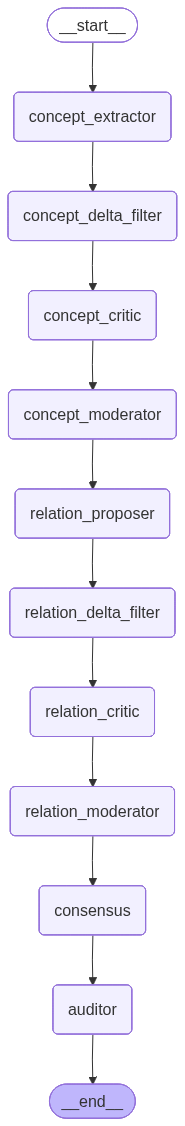

In [228]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(Image(app.get_graph().draw_mermaid_png()))

Usando decorator do **Langsmith** para poder visualizar os logs dos agentes na plataforma.

In [168]:
from langsmith import traceable

@traceable(run_type="chain", name="Chapter run")
def invoke_extractor(initial_state: AgentState):
    return app.invoke(initial_state)

#### Exemplo com uma pequena amostra

![x](./imgs/langsmith-trace.png)


In [175]:
sample_text = """
To understand Backpropagation, one must first grasp the Chain Rule of calculus. 
However, before diving into calculus, a basic understanding of Functions is required.
Inductive Logic is unrelated to this specific derivation tree.
"""

known_concepts = ["Backpropagation", "Chain Rule", "Functions", "Inductive Logic"]

global_kb = KnowledgeGraph(concepts=[], relations=[])
initial_state = {
            "text_segment": sample_text,
            "knowledge_base": global_kb,
            # Init empty lists for required fields
            "extracted_concepts": [], "new_concepts": [], "known_concepts": [],
            "concept_critiques": [], "moderated_new_concepts": [], "active_concepts": [],
            "proposed_relations": [], "new_relations": [], "relation_critiques": [],
            "moderated_new_relations": [], 
            "final_graph_update": KnowledgeGraph(concepts=[], relations=[]),
            "workflow_trace": []
}


final_state = invoke_extractor(initial_state)
for x in final_state['final_graph_update'].concepts:
    print(x)

print('\n')

for x in final_state['final_graph_update'].relations:
    print(x)

name='Backpropagation' description='An algorithm for computing gradients of loss functions with respect to parameters in neural networks using reverse-mode automatic differentiation.'
name='Chain Rule' description='A rule in calculus for computing the derivative of a composite function.'
name='Calculus' description='A branch of mathematics focused on limits, derivatives, integrals, and infinite series.'
name='Functions' description='Mathematical mappings that assign each element of a domain to exactly one element of a codomain.'
name='Inductive Logic' description='A branch of logic concerned with reasoning from specific observations to general conclusions or theories.'


source='Chain Rule' target='Backpropagation' relation_type='prerequisite' context='Understanding the Chain Rule is required to follow how backpropagation computes derivatives through composed functions in a neural network.'
source='Functions' target='Calculus' relation_type='prerequisite' context='A basic understanding

In [ ]:
@traceable(run_type="chain", name="EBookExtractorAgent")
def build(concepts: List[Concept], kg: KnowledgeGraph = None, output_dir='', start_chapter = 0, chapters_to_extract = 1) -> KnowledgeGraph:
    """
    Build the graph containing the initial concepts, new concepts learned and the relation
    between them.
    
    :param conceps: A list of chapters. The function will look for a directory under ``output_dir`` and get 
    the file ``document.md``.
    :param kg: KnowledgeGraph object, if it's not None, the function will use it and update.
    :param start_chapter: the chapter to start analyze.
    :param chapters_to_extract: Number of chapters to extract.
    """

    # global knowledge base
    global_kb = kg
    if kg == None:
        global_kb = KnowledgeGraph(concepts=[], relations=[])

    files = {}
    folder_name = ''
    folder_count = 0
    for idx, concept in enumerate(concepts):
        if len(concept.chapter) == 1:
            folder_count += 1
            folder_name = normalize_filename(concept.concept_name)
            files[(folder_name, folder_count)] = []
            
        # node_id = normalize_filename(concept.concept_name)
        files[(folder_name, folder_count)].append(concept.concept_name)
    
    sorted_files = sorted(files.keys(), key=lambda x: x[1])
    files_to_extract = sorted_files[start_chapter : start_chapter + chapters_to_extract]
    
    for folder, idx in tqdm_notebook(files_to_extract, desc="Creating relations and new nodes..."):
        
        file_path = os.path.join(output_dir, folder, "document.md")
        if not os.path.exists(file_path):
            continue
        
        print(f"Analyzing: {folder}")
        
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read()

        # Calling the pipeline
        state_input = {
            "text_segment": content,
            "knowledge_base": global_kb,
            "extracted_concepts": [], "new_concepts": [], "known_concepts": [],
            "concept_critiques": [], "moderated_new_concepts": [], "active_concepts": [],
            "proposed_relations": [], "new_relations": [], "relation_critiques": [],
            "moderated_new_relations": [], 
            "final_graph_update": KnowledgeGraph(concepts=[], relations=[]),
            "workflow_trace": []
        }
        
        final_state: AgentState = invoke_extractor(state_input, langsmith_extra={"name": folder})
        
        delta = final_state['final_graph_update']
        
        print(f"--- Chapter {idx+1} Delta ---")
        print(f"New Concepts: {len(delta.concepts)}")
        print(f"New Relations: {len(delta.relations)}")
        
        # Update kg data with new concepts and relations
        global_kb.concepts.extend(delta.concepts)
        global_kb.relations.extend(delta.relations)
        
        print(f"--- Global KB Status ---")
        print(f"Total Concepts: {len(global_kb.concepts)}")
        print(f"Total Relations: {len(global_kb.relations)}")
        # break
         
    return global_kb


## Agentes Validação Cruzada

Para os agentes de validação cruzada foi utilizado apenas o **Langchain** com ``create_agent``. Em uma primeira tentativa com um modelo com apenas um proponente e outro validator, o grafo ficou muito estenso e complexo. Já após colocar uma validação cruzada com dois proponentes e dois validadores, acabou que poucos conceitos e quase nenhuma relações eram selecionadas. Como a estratégia de multiagentes funcionou melhor, decidir já parar no início para não gastar mais tokens desnecessáriamente, além do tempo que levava para cada iteração.

In [ ]:
class ValidationResult(BaseModel):
    valid_concepts: List[Concept]
    reject_concepts: List[Concept]
    valid_relations: List[Relation]
    rejected_relations: List[Relation] 
    
class KnowledgeGraph(BaseModel):
    """The final, polished output from the Consensus Agent."""
    concepts: List[Concept]
    relations: List[Relation]

In [276]:
from langchain.agents import create_agent
from langchain_core.messages import SystemMessage, HumanMessage


class ValidatorAgent():
    agent_number = 1
    prompt = SystemMessage("""
        You are a Strict Quality Control Agent for an Educational Knowledge Graph.
        
        Your Goal: Review the <RELATIONS> and <CONCEPTS> extracted from a <TEXT>.
        Filter out noise to ensure high-quality graph nodes.
    
        **ACCEPTANCE CRITERIA**:
        1. **Focus**: The concepts must be strong related to what is being debated on the text, not only mentions.
        2. **Correlation**: The relations must be strong, such that someone would struggle to learn the source
        concept without understand the target  
        """)
    
    def __init__(self, llm: BaseChatModel):

        self.agent_name = f"ValidatorAgent_{ValidatorAgent.agent_number}"

        self.validator_agent = create_agent(
            name=self.agent_name,
            model=llm,
            middleware=[],
            tools=[],
            system_prompt=ValidatorAgent.prompt,
            response_format=ValidationResult
        )
        
        ValidatorAgent.agent_number += 1

    def invoke(self, kg: KnowledgeGraph) -> ValidationResult:
        concepts_str = "\n- ".join([c.name for c in kg.concepts])
        relations_str = "\n- ".join([f"{rel.source}-[PREREQUISITE]->{rel.target}" for rel in kg.relations])
        # Pass a dict, not a HumanMessage
        result: ValidationResult = self.validator_agent.invoke(input={
            "messages": [HumanMessage(content=f"<CONCEPTS>:\n{concepts_str}\n\n<RELATIONS>:\n{relations_str}")]
        })
        return result['structured_response']
        

In [277]:
class CreatorAgent():
    agent_number = 1
    prompt = SystemMessage("""
        You are a Knowledge Graph Architect. You have two tasks:
        1. Identify the core <CONCEPTS> within the <CONTENT>.
        2. Identify the <RELATION> **prerequisite** between the generated <CONCEPTS> and/or <PREVIOUSLY KNOWN CONCEPTS>.
                        
        ### RULES:
        1. The concepts must be core ideas inside the text.
        2. Do not select sentences, but keywords instead (e.g. Integral, Linux, Kernel, English, Noun, etc).
        3. Do not re-create a concept that is alredy within <PREVIOSLY KNOW CONCEPTS>
        3. Select only the concepts that are being strongly debated on the text, do not choose one that is merely mentioned.
        4. If you are creating a prerequisite relation between current concepts, the
        target must have been taught before source.
        5. You can create relations between <CONCEPTS> or <PREVIOUSLY KNOWN CONCEPTS>

    """)
    def __init__(self, llm: BaseChatModel):
        self.agent_name = f"CreatorAgent_{CreatorAgent.agent_number}"

        self.creator_agent = create_agent(
            name=self.agent_name,
            model=llm,
            tools=[],
            system_prompt=CreatorAgent.prompt,
            response_format=KnowledgeGraph
        )
        
        CreatorAgent.agent_number += 1

    def invoke(self, previous_concepts_str: str, text_content: str) -> KnowledgeGraph:
        human_message = HumanMessage(
            content=f"""<PREVIOUSLY KNOWN CONCEPTS>:\n{previous_concepts_str}\n\n<CONTENT>:\n{text_content}""")
        return self.creator_agent.invoke(input={"messages": [human_message]})['structured_response']
    

In [278]:
creator_agent_1 = CreatorAgent(get_llm(Models.GPT5_1))
creator_agent_2 = CreatorAgent(get_llm(Models.GPT5_1))
validator_agent_1 = ValidatorAgent(get_llm(Models.GPT5_1))
validator_agent_2 = ValidatorAgent(get_llm(Models.GPT5_1))


def run_pair(c_kg: KnowledgeGraph, v: ValidatorAgent):
    result: ValidationResult = v.invoke(c_kg)
    c_set = set(result.valid_concepts)
    r_set = set(result.valid_relations)
    return c_set, r_set
    

@traceable(run_type="chain", name="CrossValidationChapter")
def run_creator_then_validator(kg: KnowledgeGraph, text_content: str) -> KnowledgeGraph:
    previous_concepts_str = '\n-'.join([c.name for c in kg.concepts])

    # creators
    creator_result_1: KnowledgeGraph = creator_agent_1.invoke(previous_concepts_str, text_content)
    creator_result_2: KnowledgeGraph = creator_agent_2.invoke(previous_concepts_str, text_content)

    # validators
    c1, r1 = run_pair(creator_result_1, validator_agent_1)
    c2, r2 = run_pair(creator_result_1, validator_agent_2)
    c3, r3 = run_pair(creator_result_2, validator_agent_1)
    c4, r4 = run_pair(creator_result_2, validator_agent_2)

    concepts_set = [c1, c2, c3, c4]
    relations_set = [r1, r2, r3, r4]

    c_final = set.intersection(*concepts_set)
    r_final = set.intersection(*relations_set)

    print(c_final)
    print(r_final)

    kg.concepts.extend(c_final)
    kg.concepts.extend(r_final)

    return kg

In [ ]:
kg_state = KnowledgeGraph(concepts=[], relations=[])

text_content = """In this chapter, we explore the Linux File System and its permissions model. 
Understanding file permissions is crucial for managing access to files and directories in a multi-user environment.
File permissions in Linux are defined using a combination of read, write, and execute flags for the owner, group, and others."""

run_creator_then_validator(kg_state, text_content)

In [280]:
@traceable(run_type="chain", name="EBookExtractorAgent")
def build(concepts: List[Concept], kg: KnowledgeGraph = None, output_dir='', start_chapter = 0, chapters_to_extract = 1) -> KnowledgeGraph:
    """
    Build the graph containing the initial concepts, new concepts learned and the relation
    between them.
    
    :param conceps: A list of chapters. The function will look for a directory under ``output_dir`` and get 
    the file ``document.md``.
    :param kg: KnowledgeGraph object, if it's not None, the function will use it and update.
    :param start_chapter: the chapter to start analyze.
    :param chapters_to_extract: Number of chapters to extract.
    """

    # global knowledge base
    global_kb = kg
    if kg == None:
        global_kb = KnowledgeGraph(concepts=[], relations=[])

    files = {}
    folder_name = ''
    folder_count = 0
    for idx, concept in enumerate(concepts):
        if len(concept.chapter) == 1:
            folder_count += 1
            folder_name = normalize_filename(concept.concept_name)
            files[(folder_name, folder_count)] = []
            
        # node_id = normalize_filename(concept.concept_name)
        files[(folder_name, folder_count)].append(concept.concept_name)
    
    sorted_files = sorted(files.keys(), key=lambda x: x[1])
    files_to_extract = sorted_files[start_chapter : start_chapter + chapters_to_extract]
    
    for folder, idx in tqdm_notebook(files_to_extract, desc="Creating relations and new nodes..."):
        
        file_path = os.path.join(output_dir, folder, "document.md")
        if not os.path.exists(file_path):
            continue
        
        print(f"Analyzing: {folder}")
        
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read()

        
        final_state: KnowledgeGraph = run_creator_then_validator(global_kb, content, langsmith_extra={"name": folder})
        
        print(f"--- Chapter {idx+1} Delta ---")
        print(f"New Concepts: {len(final_state.concepts)}")
        print(f"New Relations: {len(final_state.relations)}")
        
        # Update kg data with new concepts and relations
        global_kb.concepts.extend(final_state.concepts)
        global_kb.relations.extend(final_state.relations)
        
        print(f"--- Global KB Status ---")
        print(f"Total Concepts: {len(global_kb.concepts)}")
        print(f"Total Relations: {len(global_kb.relations)}")
        # break
         
    return global_kb

In [281]:
res = build(toc_concepts, None, base_output_dir, 0, 1)

Creating relations and new nodes...:   0%|          | 0/1 [00:00<?, ?it/s]

Analyzing: introducao_ao_linux


2025-12-15 00:42:51,707 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-15 00:43:10,446 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-15 00:43:20,628 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-15 00:43:39,945 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-15 00:44:08,610 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-12-15 00:44:24,584 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{Concept(name='Open Source', description='Modelo de desenvolvimento e licença de software com código aberto e colaborativo.'), Concept(name='Linux', description='Sistema operacional livre e de código aberto, base para vários tópicos do texto.')}
set()
--- Chapter 2 Delta ---
New Concepts: 2
New Relations: 0
--- Global KB Status ---
Total Concepts: 4
Total Relations: 0


## Visualização e persistência do gráfico

``GraphXMLBUilder`` recebe um objeto da classe ``KnowledgeBase`` e cria dos arquivos **nodes.xml** e **relations.xml**, representando a estrutura do grafo.

In [ ]:
from typing import List, Optional, Literal
from pydantic import BaseModel, Field
from pathlib import Path
import xml.etree.ElementTree as ET

class GraphXMLBuilder():
    """Receives a KnowledgeGraph instance and builds the XML files nodes.xml and relations.xml.
    
    :param kg: KnowledgeGraph object.
    :output_dir: Desired output path.
    """
    def __init__(self, kg: KnowledgeGraph, output_dir: Optional[Path] = None):
        self.kg = kg
        self.output_dir = output_dir or Path('.')
        self.nodes_path = self.output_dir / "nodes.xml"
        self.relations_path = self.output_dir / "relations.xml"

    def save(self):
        # Build nodes.xml
        root_nodes = ET.Element("nodes")
        for idx, concept in enumerate(self.kg.concepts):
            node = ET.SubElement(root_nodes, "node")
            node.set("id", concept.name.replace(' ', '_').lower())
            node.set("name", concept.name)
            node.set("description", getattr(concept, 'description', ''))
            node.set("order", str(idx))

        # Build relations.xml
        root_rels = ET.Element("relations")
        for rel in self.kg.relations:
            rel_elem = ET.SubElement(root_rels, "relation")
            rel_elem.set("type", rel.relation_type)
            rel_elem.set("source", rel.source.replace(' ', '_').lower())
            rel_elem.set("target", rel.target.replace(' ', '_').lower())
            if rel.context:
                context_elem = ET.SubElement(rel_elem, "context")
                context_elem.text = rel.context

        # Save pretty XML
        xml_nodes_str = prettify_xml(root_nodes)
        with open(self.nodes_path, "w", encoding="utf-8") as f:
            f.write(xml_nodes_str)

        xml_rels_str = prettify_xml(root_rels)
        with open(self.relations_path, "w", encoding="utf-8") as f:
            f.write(xml_rels_str)

        print(f"Updated {self.nodes_path} and {self.relations_path}")

In [214]:
kg_builder = GraphXMLBuilder(res, base_output_dir)
kg_builder.save()

Updated ebooks/LinuxFundamentals/nodes.xml and ebooks/LinuxFundamentals/relations.xml


``InteractiveGraphVisualizer`` (Criado com IA): Classe para visualizar o grafo. O tamanho dos nós é proporcional ao número de conexões que o mesmo possue. Além disso é implementado uma clusterização dos nós, permitindo uma melhor visualização dos blocos de nós que mais se relacionam.

In [230]:
import os
import xml.etree.ElementTree as ET
from pyvis.network import Network
import networkx as nx
from pathlib import Path

class InteractiveGraphVisualizer:
    def __init__(self, knowledge_graph: KnowledgeGraph, output_dir):
        """
        Initializes the visualizer.
        
        Args:
            knowledge_graph: The KnowledgeGraph object (context/source).
            output_dir (str or Path): The directory containing the XML files and where HTML will be saved.
        """
        self.kg = knowledge_graph
        self.output_dir = Path(output_dir)
        
        # Define paths
        self.nodes_path = self.output_dir / "nodes.xml"
        self.relations_path = self.output_dir / "relations.xml"
        self.output_html = self.output_dir / "graph.html"
        
        # Initialize Graph
        self.G = nx.DiGraph()
        
        # Configuration / Palettes
        self.level_palette = {
            0: "#f0a202", # Gold (Root)
            1: "#22577a", # Dark Blue (Chapters)
            2: "#38a3a5", # Teal (Sections)
            3: "#57cc99", # Mint (Sub-sections)
            4: "#80ed99", # Light Green
            5: "#c7f9cc"  # Pale Green
        }
        
        self.cluster_palette = [
            "#E63946", "#F1FAEE", "#A8DADC", "#457B9D", "#1D3557", 
            "#F4A261", "#2A9D8F", "#E9C46A", "#D62828", "#023E8A", 
            "#FF006E", "#8338EC", "#3A86FF", "#FB5607", "#FFBE0B" 
        ]

    def _get_node_color_by_level(self, level_str):
        """Returns a color hex code based on hierarchy level."""
        try:
            level = int(level_str)
        except (ValueError, TypeError):
            level = 1
        return self.level_palette.get(level, "#c7f9cc")

    def _load_nodes(self):
        """Parses nodes.xml and adds nodes to the graph."""
        if not self.nodes_path.exists():
            print(f"❌ Nodes XML not found at: {self.nodes_path}")
            return False

        tree_nodes = ET.parse(self.nodes_path)
        for node in tree_nodes.findall("node"):
            node_id = node.get("id")
            name = node.get("name")
            node_type = node.get("type", "chapter")
            level = node.get("level", "1")

            title = f"Type: {node_type}\nLevel: {level}"
            
            # Initial Coloring
            if node_type == "extracted":
                color = "#ffafcc"
                found_in = node.get("found_in_chapter", "unknown")
                title += f"\nFound in: {found_in}"
            elif node_type == "root":
                color = self._get_node_color_by_level(0)
            else:
                color = self._get_node_color_by_level(level)

            self.G.add_node(node_id, label=name, title=title, color=color, shape="dot")
        return True

    def _load_edges(self):
        """Parses relations.xml and adds edges to the graph."""
        if not self.relations_path.exists():
            print(f"❌ Relations XML not found at: {self.relations_path}")
            return False

        tree_rels = ET.parse(self.relations_path)
        for rel in tree_rels.findall("relation"):
            source = rel.get("source")
            target = rel.get("target")
            rel_type = rel.get("type")

            # Edge Styling
            color = "#888888"
            width = 1
            dashes = False

            if rel_type == "prerequisite":
                color = "#ff3366"; width = 3
            elif rel_type == "part-of":
                color = "#4a90e2"; dashes = True
            elif rel_type == "including":
                color = "#00b4d8"; dashes = True
            elif rel_type == "definition":
                color = "#9b5de5"; width = 2
            elif rel_type == "property":
                color = "#f15bb5"

            if self.G.has_node(source) and self.G.has_node(target):
                self.G.add_edge(source, target, title=rel_type, color=color, width=width, dashes=dashes)
        return True

    def _calculate_sizes(self):
        """Updates node sizes based on connection degree."""
        print("⚖️  Recalculating node sizes based on connection count...")
        base_size = 10
        multiplier = 4
        
        for node_id in self.G.nodes():
            degree = self.G.degree[node_id]
            new_size = base_size + (degree * multiplier)
            self.G.nodes[node_id]['size'] = new_size
            self.G.nodes[node_id]['title'] += f"\nConnections: {degree}"

    def _apply_clustering(self):
        """Detects communities and updates node colors."""
        print("🧩 Detecting communities (clusters)...")
        G_undirected = self.G.to_undirected()
        communities = nx.community.greedy_modularity_communities(G_undirected)

        for i, comm in enumerate(communities):
            comm_color = self.cluster_palette[i % len(self.cluster_palette)]
            for node_id in comm:
                if node_id in self.G.nodes:
                    self.G.nodes[node_id]['color'] = comm_color
                    self.G.nodes[node_id]['title'] += f"\nCluster: {i + 1}"
        
        print(f"✅ Detected {len(communities)} communities.")

    def _get_pyvis_options(self):
        """Returns the JSON string for PyVis configuration."""
        return """
        var options = {
          "nodes": {
            "borderWidth": 0,
            "borderWidthSelected": 2,
            "font": { "size": 14, "face": "tahoma", "color": "#eeeeee", "strokeWidth": 2, "strokeColor": "#1e1e1e" },
            "shadow": { "enabled": true, "color": "black", "size": 5, "x": 2, "y": 2 }
          },
          "edges": {
            "smooth": { "type": "continuous", "forceDirection": "none" },
            "arrows": { "to": { "enabled": true, "scaleFactor": 0.5 } },
            "color": { "inherit": false, "opacity": 1.0 }
          },
          "interaction": {
            "hover": true,
            "hoverConnectedEdges": true,
            "selectConnectedEdges": true,
            "navigationButtons": true,
            "keyboard": true,
            "tooltipDelay": 200
          },
          "physics": {
            "stabilization": { "enabled": true, "iterations": 1000 },
            "barnesHut": { "gravitationalConstant": -8000, "springConstant": 0.001, "springLength": 200 }
          }
        }
        """

    def generate(self):
        """Main method to generate the interactive graph."""
        print("📊 Constructing NetworkX Graph...")
        
        if not self._load_nodes(): return
        if not self._load_edges(): return

        self._calculate_sizes()
        self._apply_clustering()

        print(f"🕸️  Graph created with {self.G.number_of_nodes()} nodes and {self.G.number_of_edges()} edges.")
        print("🎨 Generating Obsidian-like HTML Visualization...")

        net = Network(
            height="900px", 
            width="100%", 
            bgcolor="#1e1e1e", 
            font_color="#cccccc", 
            select_menu=False, 
            filter_menu=False, 
            cdn_resources='in_line'
        )
        
        net.from_nx(self.G)
        net.set_options(self._get_pyvis_options())
        
        # Ensure output directory exists before saving
        self.output_dir.mkdir(parents=True, exist_ok=True)
        
        net.save_graph(str(self.output_html))
        print(f"✅ Visualization saved to: {self.output_html.resolve()}")

# Example Usage (You can copy this into your notebook cell):
visualizer = InteractiveGraphVisualizer(kg, base_output_dir)
visualizer.generate()

📊 Constructing NetworkX Graph...
⚖️  Recalculating node sizes based on connection count...
🧩 Detecting communities (clusters)...
✅ Detected 48 communities.
🕸️  Graph created with 439 nodes and 485 edges.
🎨 Generating Obsidian-like HTML Visualization...
✅ Visualization saved to: /home/pras/Documents/LAMIA/EMBRAPII/4LINUX/notebooks/ebooks/LinuxFundamentals/knowledge_graph.html
